# <span style='font-family:"Times New Roman"'> <span styel=''>**GLIOMA ANALYSIS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we want to understand what makes Glioma an outlier for the patterns we saw, and what are the major subcohorts that drive the outlying signal.

---

In [17]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

## Interesting functions

In [92]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
    
    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)

    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax

# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)

## Master Definition and Filtering

In [2]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

master_no_wgd_glioma = master_no_wgd[master_no_wgd['Cancer_Type'] == 'Glioma']
master_wgd_glioma = master_wgd[master_wgd['Cancer_Type'] == 'Glioma']

# What makes Glioma an Outlier?

## WGD Proportion

Glioma is the cancer with the lowest WGD proportion, around 5%:
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel - Non WGD Cohort

<img src="subgroup_proportion.png">

Glioma is highly enriched in Primary Samples, in *>1muts* subgroup and in composite mutation samples in general

## Genome Instability

<img src="gi_pancancer_frac_no_wgd.png">

Glioma is one of the three cancers that shows an outlying signal in Genome Instability Pattern: while almost all cancers have a correlation between tp53 bi allelic state, Glioma, Pancreatic Cancer an d Melanoma do not show this GI difference.

# Cancer Investigation
Arising questions:
* What is the tp53 mutation Hotspot distribution and correlation to the Genome Instability difference?
* What is the CCF distribution across the cancer and what are the correlation with Genome Instability?
* What are the clinical outcomes for the different subcohorts?

## Hotspot distribution

<img src="mut_hotspot.png" width=500 length=500>

Mutation hotspot pattern displayed in the cancer panel is not easy to interpret for now. Let's see if by splitting the cohort between hotspot and non hotspot mutations, we see GI differences within the cohort.

### Mutation Hotspot overall distribution

,175,248,273,hotspot,in_frame,missense,truncated
count,26,30,50,33,17,215,94


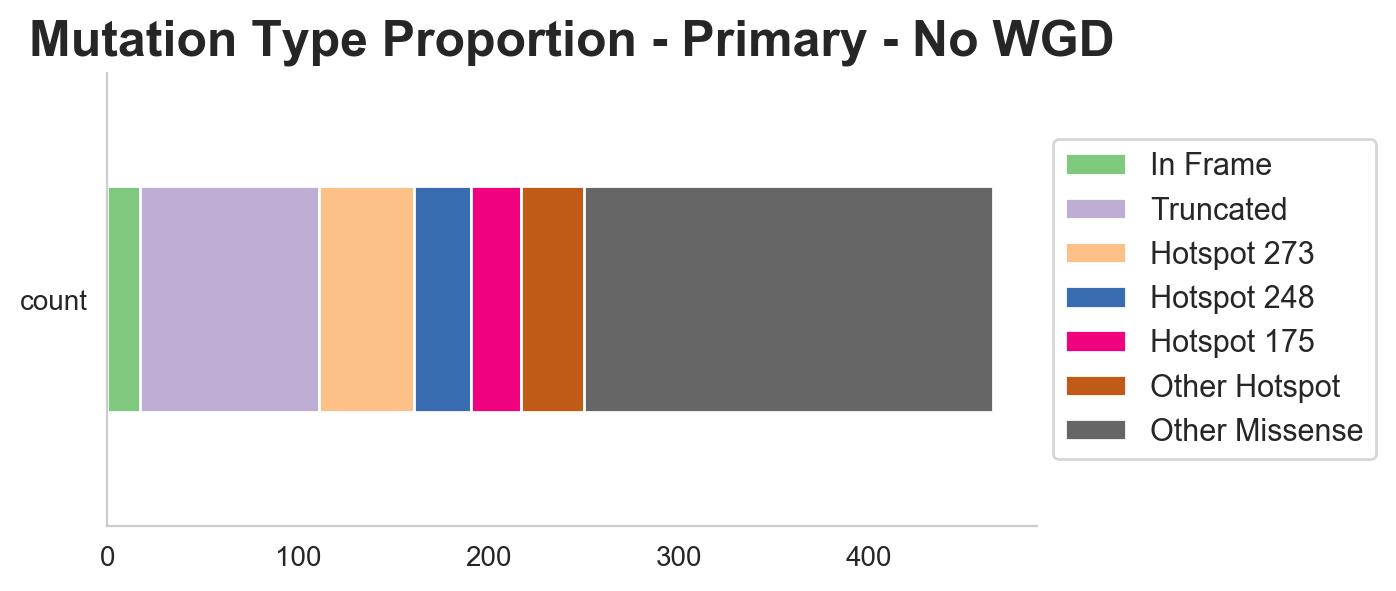

In [33]:
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(6,3))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

data_prim = master_no_wgd_glioma[master_no_wgd_glioma['Sample_Type'] == 'Primary']
data_met = master_no_wgd_glioma[master_no_wgd_glioma['Sample_Type'] == 'Metastasis']
data_1p = get_groupby(data_prim,'tp53_vc_group_1', 'count'); data_2p = get_groupby(data_prim,'tp53_vc_group_2', 'count'); data_3p = get_groupby(data_prim,'tp53_vc_group_3', 'count') ; data_4p = get_groupby(data_prim,'tp53_vc_group_4', 'count') ; data_5p = get_groupby(data_prim,'tp53_vc_group_5', 'count') 
data_1m = get_groupby(data_met,'tp53_vc_group_1', 'count'); data_2m = get_groupby(data_met,'tp53_vc_group_2', 'count'); data_3m = get_groupby(data_met,'tp53_vc_group_3', 'count') ; data_4m = get_groupby(data_met,'tp53_vc_group_4', 'count') ; data_5m = get_groupby(data_met,'tp53_vc_group_5', 'count') 
series_p = [data_1p,data_2p,data_3p,data_4p,data_5p]
series_m = [data_1m,data_2m,data_3m,data_4m,data_5m]
for i in range(len(series_p)):
    for line in ['175', '248', '273', 'hotspot', 'in_frame', 'missense', 'truncated']:
        if line not in list(series_p[i].index):
            series_p[i] = series_p[i].append(pd.Series({'count': 0}, name=line))
for i in range(len(series_m)):
    for line in ['175', '248', '273', 'hotspot', 'in_frame', 'missense', 'truncated']:
        if line not in list(series_m[i].index):
            series_m[i] = series_m[i].append(pd.Series({'count': 0}, name=line))
count_p = series_p[0].add(series_p[1]).add(series_p[2]).add(series_p[3]).add(series_p[4])
count_m = series_m[0].add(series_m[1]).add(series_m[2]).add(series_m[3]).add(series_m[4])

countm = count_m.T.fillna(0) ; countp = count_p.T.fillna(0)

columns_m = list(countm.columns)
columns_p = list(countp.columns)

display(countp)
df = countp[['in_frame','truncated', '273', '248', '175','hotspot', 'missense']]
h = df.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Hotspot 273','Hotspot 248','Hotspot 175', 'Other Hotspot', 'Other Missense'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
ax.set_title('Mutation Type Proportion - Primary - No WGD', weight='bold', fontsize=18)

plt.show()

In [77]:
df_merged = get_hotspots(df=master_no_wgd_glioma, 
             Sample_Type='Primary', 
             group=None, 
             group_type=None)

display(pd.DataFrame(df_merged.head(10)['total']))

,total
273,50.0
248,30.0
175,26.0
282,13.0
342,13.0
158,13.0
245,12.0
193,10.0
238,9.0
213,9.0


In [131]:
print('Importance of the top 5 hotspots in total mutations: ' + str(round(100*df_merged.head(5)['total'].sum()/df_merged['total'].sum())) + ' %')
      

Importance of the top 5 hotspots in total mutations: 31.0 %


#### Differences of hotspots between subgroups

In [88]:
df_merged_muts = get_hotspots(df=master_no_wgd_glioma, 
             Sample_Type='Primary', 
             group=['>1muts'], 
             group_type='tp53_group')[['total']]

df_merged_cnloh = get_hotspots(df=master_no_wgd_glioma, 
             Sample_Type='Primary', 
             group=['>=1_cnLOH'], 
             group_type='tp53_group')[['total']]

df_merged_wt = get_hotspots(df=master_no_wgd_glioma, 
             Sample_Type='Primary', 
             group=['1_WILD_TYPE'], 
             group_type='tp53_group')[['total']]

df_merged_muts.columns = ['>1muts']
df_merged_cnloh.columns = ['>=1_cnLOH']
df_merged_wt.columns = ['1_WILD_TYPE']

display_side_by_side(df_merged_muts.head(10), df_merged_cnloh.head(10), df_merged_wt.head(10))

,>1muts
273,22.0
175,12.0
248,7.0
158,7.0
342,7.0
245,5.0
282,4.0
195,4.0
278,4.0
244,4.0


### Genome Instability difference
First let's see if we have GI differences between different cohort of tp53 mutations.
(We want to find which subcohort is leading the signal of GI)

#### Missense VS Truncated

In [107]:
h = pd.DataFrame(master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['missense', '175', '248', '273', 'hotpspot'])]['frac_genome_altered'].describe())
h.columns = ['frac_genome_altered - Missense']

g = pd.DataFrame(master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['truncated', 'in_frame'])]['frac_genome_altered'].describe())
g.columns = ['frac_genome_altered - Trunc/In Frame']

display_side_by_side(h,g)

statistic, p_value = ranksums(master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['missense', '175', '248', '273', 'hotpspot'])]['frac_genome_altered'].dropna().values,master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['truncated', 'in_frame'])]['frac_genome_altered'].dropna().values)
print(statistic, p_value)


,frac_genome_altered - Missense
count,251.000000
mean,0.217012
std,0.133488
min,0.000000
25%,0.126000
50%,0.199000
75%,0.269000
max,0.915000
,frac_genome_altered - Trunc/In Frame
count,93.000000


-4.226613370386216 2.3723477166383337e-05


As expected, we see a difference of Instability: truncated samples are more unstable, with a $p_{value}=2.3e-5$.

#### Missense VS Missense Hotspot

In [108]:
h = pd.DataFrame(master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['missense'])]['frac_genome_altered'].describe())
h.columns = ['frac_genome_altered - Missense']

g = pd.DataFrame(master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin([ '175', '248', '273', 'hotpspot'])]['frac_genome_altered'].describe())
g.columns = ['frac_genome_altered - Missense Hot']

display_side_by_side(h,g)

statistic, p_value = ranksums(master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin([ '175', '248', '273', 'hotpspot'])]['frac_genome_altered'].dropna().values,master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['missense'])]['frac_genome_altered'].dropna().values)
print(statistic, p_value)

,frac_genome_altered - Missense
count,161.000000
mean,0.219559
std,0.119121
min,0.000000
25%,0.137000
50%,0.210000
75%,0.274000
max,0.799000
,frac_genome_altered - Missense Hot
count,90.000000


-1.5273060406563028 0.12668492809859772


Here we do not see a clear GI difference, distributiuon are about the same.

In [99]:
master_no_wgd_glioma[master_no_wgd_glioma['tp53_vc_group_1'].isin(['truncated', 'in_frame'])]['frac_genome_altered'].describe()

count    93.000000
mean      0.291194
std       0.165692
min       0.046000
25%       0.176000
50%       0.280000
75%       0.355000
max       0.906000
Name: frac_genome_altered, dtype: float64

In [96]:
get_groupby(master_no_wgd_glioma, 'tp53_vc_group_1', 'count')

,count
tp53_vc_group_1,
175,12
248,30
273,48
hotspot,26
in_frame,15
missense,161
truncated,78


## CCF Exploration

## Clinical correlates analysis

In [110]:
get_groupby(master_no_wgd, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,2431
1_WILD_TYPE,496
>1muts,428
>=1_LOSS,3465
>=1_cnLOH,679
HOMDEL,139


In [111]:
master_no_wgd.shape[0]

15515

In [112]:
master_before = pd.read_pickle(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')

In [113]:
master_before.shape[0]

16034

In [116]:
get_groupby(master_before, 'tp53_group', 'count').sum()

count    8157
dtype: int64

In [122]:
master_before[master_before['tp53_cn_state'] == 'GAIN'].shape[0]

281

In [125]:
get_groupby(master_no_wgd, 'tp53_cn_state', 'count')

,count
tp53_cn_state,
AMP,11
AMP (BALANCED),3
CNLOH,813
CNLOH & GAIN,46
DIPLOID,8292
GAIN,281
HETLOSS,5896
HOMDEL,139
TETRAPLOID,34


In [130]:
master_no_wgd[master_no_wgd['tp53_group'] == '1_WILD_TYPE'][master_no_wgd['tp53_vc_group_1'].isin(['273'])]['frac_genome_altered'].describe()

count    45.000000
mean      0.157356
std       0.138189
min       0.000000
25%       0.063000
50%       0.106000
75%       0.224000
max       0.637000
Name: frac_genome_altered, dtype: float64

In [ ]:
master_no_wgd[master_no_wgd['tp53_group'] == '1_WILD_TYPE'][master_no_wgd['tp53_vc_group_1'].isin([])]['frac_genome_altered'].describe()

NameError: name 'master' is not defined